In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path 

import os

import torch
import torch.optim as optim

import random 

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig

In [2]:
import fastai
import transformers

In [3]:
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)

fastai version : 1.0.58
transformers version : 2.5.1


In [4]:
torch.cuda.empty_cache()

# The movie review dataset

The first thing is to train a model that works on a similar dataset that the one I'm going to work and then try to apply the same solution, potentially tweaking it to improve results.

The movie review dataset is a famous one and here will be used for the task of multi-class classification.

For each text movie review, the model has to predict a label for the sentiment. We evaluate the outputs of the model on classification accuracy. The sentiment labels are:

0 → Negative

1 → Somewhat negative

2 → Neutral

3 → Somewhat positive

4 → Positive

In [5]:
data_folder = Path('data/anime_reviews/')
train_data = pd.read_csv(data_folder / 'anime_genre_train.csv')
train_data['genre_encoded'] = train_data['genre_encoded'].astype(int)
test_data = pd.read_csv(data_folder / 'anime_genre_test.csv')
test_data['genre_encoded'] = test_data['genre_encoded'].astype(int)
print(train_data.shape, test_data.shape)
train_data.head()

(1176, 4) (294, 4)


,uid,synopsis,genre,genre_encoded
0,33854,The series focuses on the staff of the Keihime...,"[""'Comedy'"", ""'Slice of Life'""]",0
1,10020,The true end arc of Ore no Imouto. These four ...,"[""'Comedy'"", ""'Slice of Life'""]",0
2,36784,The story centers around the cheerful calico T...,"[""'Comedy'"", ""'Slice of Life'""]",0
3,37789,Picture Dramas released with the Tenchi Muyou...,"[""'Comedy'"", ""'Slice of Life'""]",0
4,20081,Grandma is a nasty and maipulative thing most ...,"[""'Comedy'"", ""'Slice of Life'""]",0


The thing to note about this dataset is that there are no full reviews but just sentences taken out of context with a sentiment label.

# Main transformers classes
In transformers, each model architecture is associated with 3 main types of classes:

A model class to load/store a particular pre-train model.

A tokenizer class to pre-process the data and make it compatible with a particular model.

A configuration class to load/store the configuration of a particular model.


For example, if you want to use the Bert architecture for text classification, you would use BertForSequenceClassification for the model class, BertTokenizer for the tokenizer class and BertConfig for the configuration class. 

In [6]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)
}

In [7]:
# Parameters
seed = 42
use_fp16 = False
bs = 4

model_type = 'roberta'
pretrained_model_name = 'roberta-base'

# model_type = 'bert'
# pretrained_model_name='bert-base-uncased'

# model_type = 'distilbert'
# pretrained_model_name = 'distilbert-base-uncased'

#model_type = 'xlm'
#pretrained_model_name = 'xlm-clm-enfr-1024'

# model_type = 'xlnet'
# pretrained_model_name = 'xlnet-base-cased'

the parameter pretrained_model_name is a string with the shortcut name of a pre-trained model/tokenizer/configuration to load, e.g 'bert-base-uncased'. We can find all the shortcut names by using the command: *model_class.pretrained_model_archive_map.keys()*

In [8]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [9]:
model_class.pretrained_model_archive_map.keys()

dict_keys(['roberta-base', 'roberta-large', 'roberta-large-mnli', 'distilroberta-base', 'roberta-base-openai-detector', 'roberta-large-openai-detector'])

In [10]:
# Util function to set the seed for generating random numbers
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

# Data pre-processing
In order to use transfer learning it is necessary to preprocess the input sequence in the same way it was done for the pre-trained model that is being used. The two main steps are to tokenize and numericalize the input text correctly. Each model requres a different pre-processing process, but fortunately that process is provided by the tokenizer class from transformers library.


In the fastai library, data pre-processing is done automatically during the creation of the DataBunch. In the DataBunch implementation, the tokenizer and numericalizer are passed in the processor argument under the following format :

processor = [TokenizeProcessor(tokenizer=tokenizer,...), NumericalizeProcessor(vocab=vocab,...)]


## Custom Tokenizer
In the fastai implementation there are three main parts :

- The TokenizeProcessor object takes as tokenizer argument a Tokenizer object.
- The Tokenizer object takes as tok_func argument a BaseTokenizer object.
- The BaseTokenizer object implement the function tokenizer(t:str) → List[str] that take a text t and returns the list of its tokens.

Therefore, it is possible to create a new class TransformersBaseTokenizer that inherits from BaseTokenizer and overwrite a new tokenizer function.

In [11]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens

In [12]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

# Custom Numericalizer
In fastai, NumericalizeProcessor object takes as vocab argument a Vocab object. In order to adapt the fastai numericalizer to the transformers models, the suggested solution is to:

- Create a new class TransformersVocab that inherits from Vocab and overwrite numericalize and textify functions.


In [13]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

# Custom processor
Now that we have our custom tokenizer and numericalizer, we can create the custom processor. Notice we are passing the include_bos = False and include_eos = False options. This is because fastai adds its own special tokens by default which interferes with the [CLS] and [SEP] tokens added by our custom tokenizer.

In [14]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

In [15]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [16]:
tokens = transformer_tokenizer.tokenize('Salut c est moi, Hello it s me')
print(tokens)
ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
print(ids)
transformer_tokenizer.convert_ids_to_tokens(ids)

['Sal', 'ut', 'Ġc', 'Ġest', 'Ġmo', 'i', ',', 'ĠHello', 'Ġit', 'Ġs', 'Ġme']
[18111, 1182, 740, 3304, 7458, 118, 6, 20920, 24, 579, 162]


['Sal', 'ut', 'Ġc', 'Ġest', 'Ġmo', 'i', ',', 'ĠHello', 'Ġit', 'Ġs', 'Ġme']

In [17]:
databunch = (TextList.from_df(train_data, cols='synopsis', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= 'genre_encoded')
             .add_test(test_data)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

/home/jacek/workspace/interactive_dashboard/env/lib/python3.6/site-packages/fastai/core.py:299: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/home/jacek/workspace/interactive_dashboard/env/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [18]:
# Check batch and tokenizer
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
databunch.show_batch()

[CLS] token : <s>
[SEP] token : </s>
[PAD] token : <pad>


/home/jacek/workspace/interactive_dashboard/env/lib/python3.6/site-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_min = (t != self.pad_idx).nonzero().min()


text,target
"<s> ĠThe Ġstory Ġbegins Ġwith Ġa Ġspaceship Ġstruggling Ġto Ġreturn Ġto Ġits Ġhome Ġworld , Ġwhich Ġcrash Ġlands Ġonto Ġa Ġdying Ġplanet , Ġtriggering Ġan Ġexplosion Ġof Ġpure Ġenergy , Ġgenerated Ġby Ġthe Ġpowerful Ġand Ġmysterious Ġlife Ġforms Ġthat Ġare Ġpilot ing Ġthe Ġcraft . ĠThis Ġoutburst Ġof Ġenergy Ġinf uses Ġthe Ġdying Ġplanet Ġwith Ġa Ġlife - gener ating Ġforce . Ġ č Ċ Ġ č Ċ Pop o",7
"<s> ĠIt Ġis Ġdecided Ġthat Ġyou Ġare Ġnot Ġneeded Ġon Ġthis Ġearth . Ġ č Ċ "" I Ġcan 't Ġtake Ġcare Ġof Ġyou Ġany Ġlonger !!"" ĠA Ġweary Ġand Ġstrong Ġmother Ġput ĠTak ashi Ġin Ġa Ġcar Ġand Ġdrove Ġto Ġa Ġdeserted Ġplace . Ġ"" No Ġmore ! ĠI Ġcan 't Ġhelp Ġit ! ĠIt 's Ġimpossible Ġfor Ġme ! ĠI 'm Ġsorry ."" ĠWith Ġthese Ġwords , Ġthe",6
"<s> ĠTe z uka ĠOs am u ĠWorld Ġis Ġlocated Ġin Ġthe ĠKyoto ĠStation ĠBuilding Ġwith Ġa Ġ300 - inch Ġtheater Ġthat Ġshows Ġhis Ġoriginal Ġshort Ġanimation Ġfilms . ĠOne Ġanimated Ġfilm Ġfilled Ġwith Ġthe Ġessence Ġof Ġhis Ġmost Ġfamous Ġpieces , Ġand Ġanother Ġthat Ġintroduces Ġa Ġhistorical Ġepisode Ġof ĠKyoto , Ġare Ġshown Ġas Ġa Ġdouble Ġfeature Ġmovie Ġwith Ġthe ĠPhoenix Ġas Ġa Ġnarrator . Ġ Ġ č Ċ",18
"<s> ĠA Ġgold fish Ġsne aks Ġaway Ġfrom Ġhome Ġand Ġfloats Ġoff Ġon Ġthe Ġback Ġof Ġa Ġjelly fish . ĠAfter Ġgetting Ġstuck Ġin Ġa Ġglass Ġjar , Ġshe Ġdr ifts Ġto Ġthe Ġshore Ġwhere Ġshe Ġis Ġfreed Ġby ĠS ous uke , Ġa Ġfive - year - old Ġboy Ġwho Ġlives Ġwith Ġhis Ġmother ĠLisa Ġin Ġa Ġhouse Ġby Ġthe Ġsea Ġwhile Ġhis Ġfather ĠKo ichi Ġworks Ġon Ġa",4


In [19]:
# Check batch and numericalizer
print('[CLS] id :', transformer_tokenizer.cls_token_id)
print('[SEP] id :', transformer_tokenizer.sep_token_id)
print('[PAD] id :', pad_idx)
test_one_batch = databunch.one_batch()[0]
print('Batch shape : ',test_one_batch.shape)
print(test_one_batch)

[CLS] id : 0
[SEP] id : 2
[PAD] id : 1
Batch shape :  torch.Size([4, 498])
tensor([[    0,    20,   527,  ..., 19307,    43,     2],
        [    0,   256,  4132,  ...,     1,     1,     1],
        [    0,    20,   569,  ...,     1,     1,     1],
        [    0,  2941,   329,  ...,     1,     1,     1]])


/home/jacek/workspace/interactive_dashboard/env/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


# Custom model
As mentioned here, every model's forward method always outputs a tuple with various elements depending on the model and the configuration parameters. In our case, we are interested to access only to the logits.  One way to access them is to create a custom model.

In [20]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        # attention_mask
        # Mask to avoid performing attention on padding token indices.
        # Mask values selected in ``[0, 1]``:
        # ``1`` for tokens that are NOT MASKED, ``0`` for MASKED tokens.
        attention_mask = (input_ids!=pad_idx).type(input_ids.type()) 
        
        logits = self.transformer(input_ids,
                                  attention_mask = attention_mask)[0]   
        return logits

To make our transformers adapted to multiclass classification, before loading the pre-trained model, we need to precise the number of labels. To do so, you can modify the config instance or either modify like in Keita Kurita's article (Section: Initializing the Learner) the num_labels argument.

In [21]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 21
config.use_bfloat16 = use_fp16
print(config)

RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "do_sample": false,
  "eos_token_id": 2,
  "eos_token_ids": null,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-05,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_beams": 1,
  "num_hidden_layers": 12,
  "num_labels": 21,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pad_token_id": 1,
  "pruned_heads": {},
  "repetition_penalty": 1.0,
  "temperature": 1.0,
  "top_k": 50,
  "top_p": 1.0,
  "torchscript": false,
  "type_vocab_

In [22]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)

custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

# Learner : Custom Optimizer / Custom Metric
In pytorch-transformers, HuggingFace had implemented two specific optimizers  -  BertAdam and OpenAIAdam  -  that have been replaced by a single AdamW optimizer. This optimizer matches Pytorch Adam optimizer Api, therefore, it becomes straightforward to integrate it within fastai. It is worth noting that for reproducing BertAdam specific behavior, you have to set correct_bias = False.

In [23]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

# Discriminative Fine-tuning and Gradual unfreezing (Optional)
To use discriminative layer training and gradual unfreezing, fastai provides one tool that allows to "split" the structure model into groups. An instruction to perform that "split" is described in the fastai documentation here.

Unfortunately, the model architectures are too different to create a unique generic function that can "split" all the model types in a convenient way. Thereby, you will have to implement a custom "split" for each different model architecture.

For example, if we use the RobBERTa model and that we observe his architecture by making print(learner.model).

In [24]:
# print(learner.model)

Once we know the architecture we can split the model like this:

In [25]:
# For DistilBERT
# list_layers = [learner.model.transformer.distilbert.embeddings,
#                learner.model.transformer.distilbert.transformer.layer[0],
#                learner.model.transformer.distilbert.transformer.layer[1],
#                learner.model.transformer.distilbert.transformer.layer[2],
#                learner.model.transformer.distilbert.transformer.layer[3],
#                learner.model.transformer.distilbert.transformer.layer[4],
#                learner.model.transformer.distilbert.transformer.layer[5],
#                learner.model.transformer.pre_classifier]

# For xlnet-base-cased
# list_layers = [learner.model.transformer.transformer.word_embedding,
#               learner.model.transformer.transformer.layer[0],
#               learner.model.transformer.transformer.layer[1],
#               learner.model.transformer.transformer.layer[2],
#               learner.model.transformer.transformer.layer[3],
#               learner.model.transformer.transformer.layer[4],
#               learner.model.transformer.transformer.layer[5],
#               learner.model.transformer.transformer.layer[6],
#               learner.model.transformer.transformer.layer[7],
#               learner.model.transformer.transformer.layer[8],
#               learner.model.transformer.transformer.layer[9],
#               learner.model.transformer.transformer.layer[10],
#               learner.model.transformer.transformer.layer[11],
#               learner.model.transformer.sequence_summary]

# For roberta-base
list_layers = [learner.model.transformer.roberta.embeddings,
              learner.model.transformer.roberta.encoder.layer[0],
              learner.model.transformer.roberta.encoder.layer[1],
              learner.model.transformer.roberta.encoder.layer[2],
              learner.model.transformer.roberta.encoder.layer[3],
              learner.model.transformer.roberta.encoder.layer[4],
              learner.model.transformer.roberta.encoder.layer[5],
              learner.model.transformer.roberta.encoder.layer[6],
              learner.model.transformer.roberta.encoder.layer[7],
              learner.model.transformer.roberta.encoder.layer[8],
              learner.model.transformer.roberta.encoder.layer[9],
              learner.model.transformer.roberta.encoder.layer[10],
              learner.model.transformer.roberta.encoder.layer[11],
              learner.model.transformer.roberta.pooler]

In [26]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
print(learner.layer_groups)

Learner split in 14 groups
[Sequential(
  (0): Embedding(50265, 768, padding_idx=1)
  (1): Embedding(514, 768, padding_idx=1)
  (2): Embedding(1, 768)
  (3): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (4): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_features=768, out_features=768, bias=True)
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=768, out_features=768, bias=True)
  (5): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=768, out_features=3072, bias=True)
  (8): Linear(in_features=3072, out_features=768, bias=True)
  (9): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (10): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2)

# Train
Now we can finally use all the fastai build-in features to train our model. Like the ULMFiT method, we will use Slanted Triangular Learning Rates, Discriminate Learning Rate and gradually unfreeze the model.

In [27]:
learner.save('untrained')

In [52]:
seed_all(seed)
learner.load('untrained');

In [53]:
# we freeze all the layers except the classifier
learner.freeze_to(-1)

In [54]:
# let's check which layer is trainable
learner.summary()

/home/jacek/workspace/interactive_dashboard/env/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [498, 768]           38,603,520 False     
______________________________________________________________________
Embedding            [498, 768]           394,752    False     
______________________________________________________________________
Embedding            [498, 768]           768        False     
______________________________________________________________________
LayerNorm            [498, 768]           1,536      False     
______________________________________________________________________
Dropout              [498, 768]           0          False     
______________________________________________________________________
Linear               [498, 768]           590,592    False     
______________________________________________________________________
Linear               [498, 768]           590,592    False     
_______________________________________

In [55]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.58E-06
Min loss divided by 10: 8.32E-07


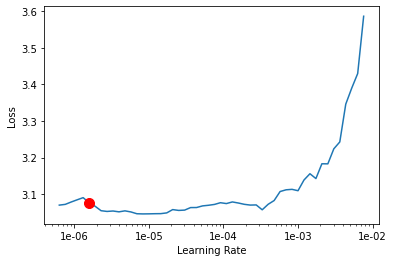

In [56]:
learner.recorder.plot(skip_end=10,suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,3.100919,3.001786,0.102564,0.897436,00:12
1,3.009919,2.954383,0.205128,0.794872,00:15


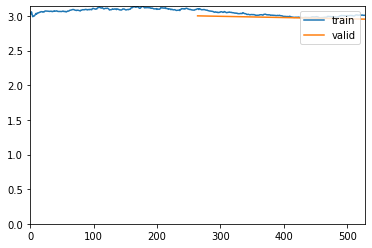

/home/jacek/workspace/interactive_dashboard/env/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [57]:
learner.fit_one_cycle(2,max_lr=2e-04,moms=(0.8,0.7))

In [58]:
learner.save('first_cycle')

In [59]:
seed_all(seed)
learner.load('first_cycle');

In [60]:
# We then unfreeze the second group of layers and repeat the operations.

learner.freeze_to(-2)

In [61]:
lr = 1e-4

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.223781,2.092576,0.299145,0.700855,00:17


/home/jacek/workspace/interactive_dashboard/env/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


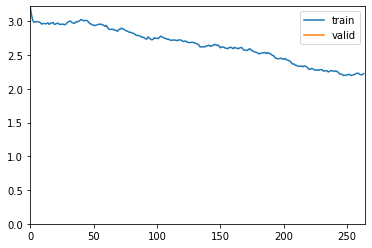

In [62]:
# Note here that we use slice to create separate learning rate for each group.

learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [63]:
learner.save('second_cycle')

In [64]:
seed_all(seed)
learner.load('second_cycle');

In [65]:
learner.freeze_to(-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.133608,2.348122,0.247863,0.752137,00:20
1,1.359887,2.076568,0.358974,0.641026,00:20


/home/jacek/workspace/interactive_dashboard/env/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


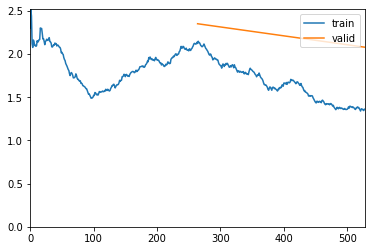

/home/jacek/workspace/interactive_dashboard/env/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [66]:
learner.fit_one_cycle(2, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))


In [44]:
learner.save('third_cycle')


In [49]:
seed_all(seed)
learner.load('third_cycle');

In [50]:
learner.unfreeze()


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.290311,2.330794,0.230769,0.769231,00:57
1,1.918125,2.063734,0.341880,0.658120,00:56
2,1.552379,2.003577,0.384615,0.615385,00:50
3,1.252370,1.906254,0.470085,0.529915,00:56
4,1.122735,1.894966,0.470085,0.529915,00:54


/home/jacek/workspace/interactive_dashboard/env/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


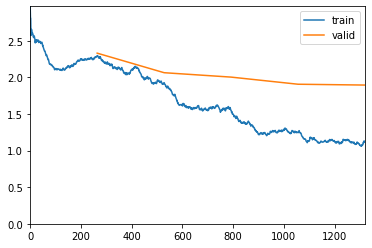

/home/jacek/workspace/interactive_dashboard/env/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/jacek/workspace/interactive_dashboard/env/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do t

In [51]:
learner.fit_one_cycle(5, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))


In [47]:
learner.export(file = 'transformer_genre.pkl');

In [48]:
path = ''
export_learner = load_learner(path, file = 'transformer_genre.pkl')


In [52]:
anime_df = pd.read_csv('data/anime_reviews/anime_genre_test.csv')

In [55]:
anime_df.head(5)

,uid,synopsis,genre,genre_encoded
0,32819,Third season of Boonie Bears . \r\n \r\nHavin...,"[""'Comedy'"", ""'Kids'""]",11.0
1,35699,Everyday objects come to life.,"[""'Kids'""]",9.0
2,35581,Come to the greatest sexual theme park in the ...,"[""'Hentai'""]",19.0
3,30127,Haruki Nakano lives an average high school lif...,"[""'Comedy'"", ""'Slice of Life'""]",0.0
4,36180,Music video for Kenshi Yonezu's song Clock Lo...,"[""'Music'""]",3.0


In [59]:
export_learner.predict(anime_df.synopsis[4].replace('\n', ''))

(Category 3,
 tensor(3),
 tensor([1.1371e-05, 3.7243e-05, 1.3502e-06, 9.8347e-01, 1.2815e-06, 2.4238e-05,
         6.8711e-06, 1.4383e-05, 2.2862e-06, 1.9482e-05, 4.4424e-04, 2.1305e-06,
         2.2467e-06, 2.7830e-06, 2.0726e-06, 2.5056e-06, 1.5891e-02, 5.6039e-05,
         3.6636e-06, 1.4615e-06]))

In [42]:
input_text_example = """To begin with Clannad is a very peculiar anime from the usual stuff i watch. The closest being Spice & Wolf as the two belong to the ‘slice of life’ genre. This is exactly what Clannad is as we follow the life of a High School Senior in Japan who just doesn’t know what he is doing with his life. On the most superficial level Clannad seems little more than a frilly series about finding love and all the stereotypes that are associated with that. To anyone who has watched the series though they will rapidly come to know that this is so far from the truth. What Clannad does so well is bring these characters, their lives, their struggles and their pains to life to the point where I felt like i was going through it with them. One by one we get a peak into the interworkings of peoples lives from the strange to the heartbreaking as everyone tries to be in it together. After all this and the typical High School anime setting the show takes a surprising turn with Clannad: After Story, which is very much dealing with what happens after ‘Happily Ever After’. This is where the struggle of finding yourself in the world and becoming one with society comes to the fore along with the struggle of holding on to what you love and the inevitable compromises that come with growing up. Clannad is a love story, and so is Clannad: After Story, but After Story is very much life as we all know it, with the good times, the bad times and everything that comes in between as we try to go through each and every day. This isn’t a show about heroes or leaders of men, but people. With Clannad i laughed, i teared up and outright sobbed with these characters to the point where i was screaming at my computer that "It isn’t fair”. Then again life is rarely fair and makes those happy moments all the more precious. Clannad in so many ways just made me feel human like little else ever has."""

In [43]:
export_learner.predict(input_text_example)

(Category 3, tensor(3), tensor([0.0016, 0.0371, 0.2809, 0.5807, 0.0997]))